### Modified from Modern Computer Vision with Pytorch

In [1]:
#!pip install -q torch_snippets
from torch_snippets import *
#!wget -q https://www.dropbox.com/s/ua1rr8btkmpqjxh/face-detection.zip
#!unzip -q face-detection.zip
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Define the Dataset class to read pairs of images and define label 0 (same class) or 1 (different classes)

In [2]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, folder, transform=None, should_invert=True):
        self.folder = folder
        self.items = Glob('{}/*/*'.format(self.folder)) 
        self.transform = transform
    def __getitem__(self, ix):
        itemA = self.items[ix]
        person = fname(parent(itemA))
        same_person = randint(2)
        if same_person:
            itemB = choose(Glob('{}/{}/*'.format(self.folder,person), silent=True))
        else:
            while True:
                itemB = choose(self.items)
                if person != fname(parent(itemB)):
                    break
        imgA = read(itemA)
        imgB = read(itemB)
        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)
        return imgA, imgB, np.array([1-same_person])
    def __len__(self):
        return len(self.items)


### Create the dataloaders for training and validation

In [3]:
from torchvision import transforms

trn_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, (0.01,0.2),
                            scale=(0.9,1.1)),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trn_ds = SiameseNetworkDataset(folder="./images/faces/training", transform=trn_tfms)
val_ds = SiameseNetworkDataset(folder="./images/faces/testing", transform=val_tfms)

trn_dl = DataLoader(trn_ds, shuffle=True, batch_size=32)
val_dl = DataLoader(val_ds, shuffle=True, batch_size=32)

### Define a Siamese network architecture

In [4]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(no),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.features = nn.Sequential(
            convBlock(1,32),
            convBlock(32,128),
            convBlock(128,256),
            nn.Flatten(),
            nn.Linear(256*13*13, 512), 
            nn.ReLU(inplace=True),
            nn.Linear(512, 64)
        )

    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

### Define a contrastive loss function

In [6]:
contrastive_thres = 1.1

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2)/2 +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))/2
        acc = ((euclidean_distance > contrastive_thres) == label).float().mean()
        return loss_contrastive, acc

### Define the training and validation functions

In [7]:
def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    return loss.item(), acc.item()

### Create the model and define its hiperparameters

In [8]:
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001, weight_decay=0.01)

### Train and evaluate the model 

In [9]:
n_epochs = 200
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(trn_dl)
    for i, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(val_dl)
    for i, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(epoch+(1+i)/N, val_loss=loss, val_acc=acc, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)

EPOCH: 20.000	trn_loss: 0.287	trn_acc: 0.615	val_loss: 0.154	val_acc: 0.866	(13.93s - 125.37s remaining)
EPOCH: 40.000	trn_loss: 0.210	trn_acc: 0.765	val_loss: 0.102	val_acc: 0.941	(25.88s - 103.50s remaining)
EPOCH: 60.000	trn_loss: 0.196	trn_acc: 0.800	val_loss: 0.074	val_acc: 0.957	(38.03s - 88.74s remaining)
EPOCH: 80.000	trn_loss: 0.182	trn_acc: 0.823	val_loss: 0.154	val_acc: 0.870	(50.05s - 75.08s remaining)
EPOCH: 100.000	trn_loss: 0.144	trn_acc: 0.846	val_loss: 0.135	val_acc: 0.906	(62.25s - 62.25s remaining)
EPOCH: 120.000	trn_loss: 0.138	trn_acc: 0.875	val_loss: 0.140	val_acc: 0.938	(74.23s - 49.49s remaining)
EPOCH: 140.000	trn_loss: 0.148	trn_acc: 0.871	val_loss: 0.133	val_acc: 0.870	(86.31s - 36.99s remaining)
EPOCH: 160.000	trn_loss: 0.118	trn_acc: 0.914	val_loss: 0.127	val_acc: 0.913	(99.29s - 24.82s remaining)
EPOCH: 180.000	trn_loss: 0.108	trn_acc: 0.923	val_loss: 0.133	val_acc: 0.913	(111.30s - 12.37s remaining)
EPOCH: 200.000	trn_loss: 0.129	trn_acc: 0.894	val_loss: 

### Report the results: underfitting occurs due to the small size of the validation set and oscillation indicates insufficient number of examples

100%|███████████████████████████████████████| 301/301 [00:00<00:00, 4455.43it/s]


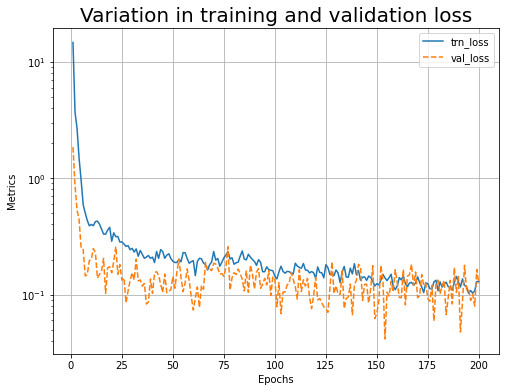

100%|███████████████████████████████████████| 301/301 [00:00<00:00, 4830.89it/s]


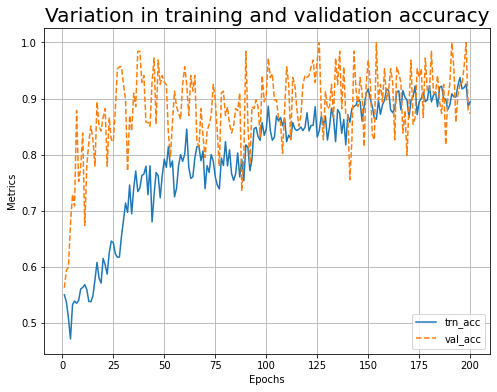

In [10]:
log.plot_epochs(['trn_loss', 'val_loss'], log=True, title='Variation in training and validation loss')
log.plot_epochs(['trn_acc', 'val_acc'], title='Variation in training and validation accuracy')

### Generate the distance histograms of each class: You must set the contrastive threshold to the value that minimizes the classification error, which is at the point the histogram profiles meet each other. Ideally, they should be separated. 

In [11]:
# Distance histograms for the cases we have the same and different persons, respectively. 
different = []
same      = []
model.eval()

for ix, data in enumerate(trn_dl):
    if (ix + 1)%100 == 0:
        print('Processing batch {}/{}'.format((ix + 1), len(trn_dl)))
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB       = model(imgsA, imgsB)
    labels               = labels.cpu()
    
    with torch.no_grad():
        euclidean_distance        = F.pairwise_distance(codesA, codesB)
        euclidean_distance        = euclidean_distance.cpu()
        
    for i in range(len(labels)): 
        if (labels[i] == 0): # same person
            same.append(euclidean_distance[i].item())
        else:
            different.append(euclidean_distance[i].item())          

[]

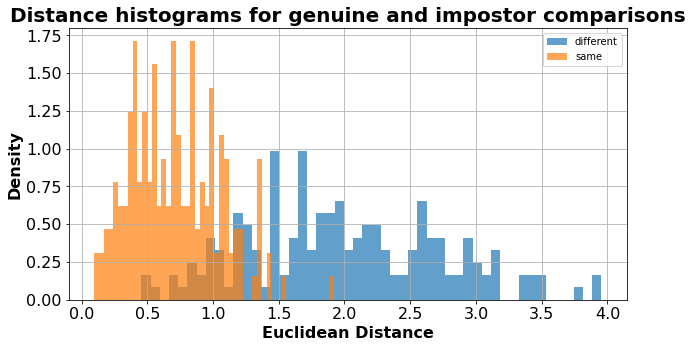

In [12]:
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title('Distance histograms for genuine and impostor comparisons', fontsize = 20, fontweight = 'bold')
ax.set_xlabel('Euclidean Distance', fontsize = 16, fontweight = 'bold')
ax.set_ylabel('Density', fontsize = 16, fontweight = 'bold')
ax.hist(different,bins = 50, density=True, alpha = 0.7, label = 'different')
ax.hist(same, bins = 50, density=True, alpha = 0.7, label = 'same')
ax.tick_params(labelsize = 16, axis = 'both')
ax.legend()
ax.grid(True)
plt.plot()

### Evaluate the model with random choices of image pairs

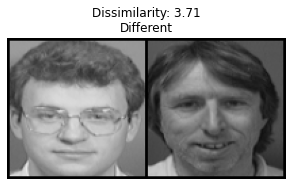

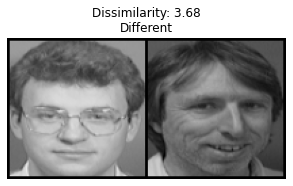

In [13]:
model.eval()
val_dl = DataLoader(val_ds,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(val_dl)
x0, _, _ = next(dataiter)

for i in range(2):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0*0.5+0.5, x1*0.5+0.5),0)
    output1,output2 = model(x0.cuda(),x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    output = 'Same Face' if euclidean_distance.item() <= contrastive_thres else 'Different'
    show(torchvision.utils.make_grid(concatenated),
         title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
    plt.show()

#### Exercise: Play with the network architecture, contrastive threshold, and other contrastive loss functions (e.g., triple loss) to improve results without overfitting and underfitting. 